# Research Question 4: Floor Effect Analysis

## 1. Question Statement and Motivation

**Question**: Does a floor effect exist in residential property prices, and does this effect differ by ``transaction`` type (``New Property`` vs. ``Resale``) and ``furnishing``?

The question is worth investigating because the floor effect provides practical and economic insights into property pricing mechanisms

By answering this question, we can:
- Quantify how much price premium is associated with higher floors.
- Determine whether this premium depends on building height (floor_total).
- Identify whether ``New Property`` and ``Resale`` markets behave differently, reflecting differences in buyer expectations, building age, and marketing strategies.

There are several targets that care about this analysis:
- **Home buyers**: can decide whether paying extra for higher floors is justified given their budget and priorities.
- **Investors**: Can evaluate whether floor premiums translate into better resale value or rental yield.

This question is a more generalized problem of many following real-world scenerios:
- *How much more should I pay for an apartment on the 12th floor compared to the 3rd floor?*
- *Is the floor premium only meaningful in high-rise buildings?*
- *Does it make sense to pay extra for a higher floor in a resale apartment?*

## 2. Preprocess

Here is the overall preprocess:
- **Initial Data Inspection**: Verified the overall structure of the dataset as well as the data type and range of related variables. For example, ``floor`` might have basement (value -1) or ground (value 0).
- **Data Converting and Filtering**: Converting the data types to a suitable ones. For example, if ``floor`` is object, we need to convert it into int for suitable process. Moreover, we need to verify the conditions, such as ``floor <= num_floor`` to make sure the current floor must be smaller than the height of the building
- **Feature Engineering**: We might want to create new feature ``floor_ratio`` which is ``floor``/``num_floor``. However, for the value -1 represent for basement, we will clip them into 0. Besides, we can introduced binary type represent if the floor is high enough to analysis the premium price between high building and low building. 
- **Outliers Elimination**: We eliminate the outliers using quantiles

## 2.1 Data Inspection

We initialize the necessary libraries and loading the cleaned dataset in ./data/processed/surat_cleaned.npy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import re
sns.set(style="whitegrid")

In [2]:
df = np.load("../data/processed/surat_cleaned.npy", allow_pickle=True)
df = pd.DataFrame(df)

We first verify the data at first before moving to the deeper preprocessing process:

In [3]:
df.head()

,property_name,areaWithType,square_feet,transaction,status,floor,furnishing,price_per_sqft,num_floor,price_lakh,bhk
0,2 BHK Apartment for Sale in Dindoli Surat,Carpet Area,644.0,New Property,Possession,5,Unfurnished,2891.0,10,33.8,2.0
1,2 BHK Apartment for Sale in Althan Surat,Super Area,1278.0,New Property,Possession,6,Unfurnished,3551.0,14,45.4,2.0
2,2 BHK Apartment for Sale in Pal Gam Surat,Super Area,1173.0,Resale,Ready to Move,5,Semi-Furnished,3800.0,13,44.6,2.0
3,2 BHK Apartment for Sale in Jahangirabad Surat,Carpet Area,700.0,New Property,Ready to Move,6,Unfurnished,3966.0,14,47.0,2.0
4,2 BHK Apartment for Sale in Palanpur Surat,Carpet Area,720.0,New Property,Possession,3,Unfurnished,3200.0,14,40.0,2.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3003 entries, 0 to 3002
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   property_name   3003 non-null   object 
 1   areaWithType    3003 non-null   object 
 2   square_feet     3003 non-null   float64
 3   transaction     3003 non-null   object 
 4   status          3003 non-null   object 
 5   floor           3003 non-null   object 
 6   furnishing      3003 non-null   object 
 7   price_per_sqft  3003 non-null   float64
 8   num_floor       3003 non-null   object 
 9   price_lakh      3003 non-null   float64
 10  bhk             3003 non-null   float64
dtypes: float64(4), object(7)
memory usage: 258.2+ KB


## 2.2 Data Converting and Filtering

We first convert the ``floor`` and ``num_floor`` to numeric

In [5]:
df["floor"] = pd.to_numeric(df["floor"], errors="coerce")
df["num_floor"] = pd.to_numeric(df["num_floor"], errors="coerce")

In [6]:
df[["floor", "num_floor"]].describe()

,floor,num_floor
count,3003.000000,3003.000000
mean,5.328005,10.294372
std,3.324646,4.572307
min,0.000000,1.000000
25%,3.000000,5.500000
50%,5.000000,12.000000
75%,7.000000,13.000000
max,20.000000,25.000000


In [7]:
valid_floor_mask = (
    (df["num_floor"] >= 1) &
    (df["floor"] >= -1) &
    (df["floor"] <= df["num_floor"])
)

df = df[valid_floor_mask].reset_index(drop=True)
df.shape

(3003, 11)

## 2.3 Feature Engineering

We then create a new feature ``floor_ratio`` represent the ratio between the current floor to the total floor of the entire building. To handle the basement scenerio, we clip them into the lowest ratio of 0 corresponding to the ground 

In [8]:
# Create a new feature column that represents the ration between the current floor and total floor (round up to 2)
df["floor_ratio"] = np.round(df["floor"] / df["num_floor"], 2)
df.loc[df["floor"] < 0, "floor_ratio"] = 0

In [9]:
df[["floor", "num_floor", "floor_ratio"]].head(10)

,floor,num_floor,floor_ratio
0,5,10,0.50
1,6,14,0.43
2,5,13,0.38
3,6,14,0.43
4,3,14,0.21
5,6,13,0.46
6,1,1,1.00
7,7,10,0.70
8,1,13,0.08
9,5,13,0.38


## 2.4 Outliers Elimination

Before moving to plotting process, we first elimninate the outliers inside the dataset

In [10]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
        
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers_iqr(df, 'price_per_sqft')

# 3. Analysis

## 3.1 Floor Effect and How it differs by ``Transaction``

So first, we need to analyse the relationship between ``floor_num`` or ``floor`` with ``price_per_sqft`` which we use scatterplot. We do not use the final price which is ``price_lakh`` because it may cause bias since it is effected by many other features so we can miss the premium effect.

- We can clearly from the below illustration that there is a positive trend ``price_per_sqft``. This means that building apartment with higher total floors will have higher price in area. 
- There also be a division between building floor in ``transaction``. Most mini-apartment or lower building (total floor range from 1 to 13 or 14) is ``Resale`` while tall building (which might be newer) is dominated with ``New Property`` transaction.

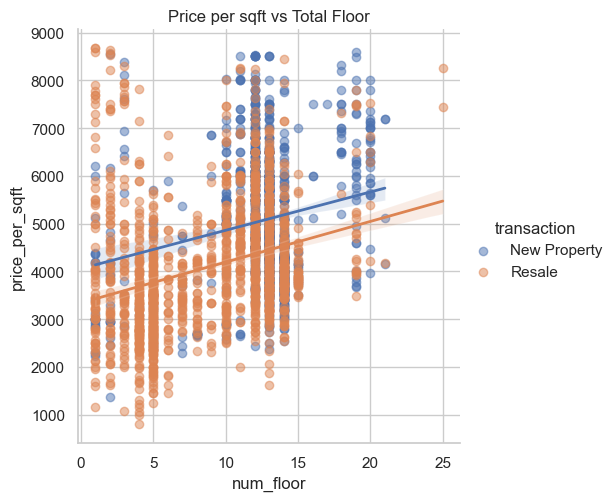

In [11]:
sns.lmplot(
    data=df,
    x="num_floor",
    y="price_per_sqft",
    hue="transaction",  
    height=5,          
    aspect=1,        
    scatter_kws={'alpha': 0.5}, 
    line_kws={'linewidth': 2}  
)

plt.title("Price per sqft vs Total Floor")
plt.show()

Similarly, if we plot the ``price_per_sqft`` with ``floor`` which represents the current floor of the building, we also get the same result which is positive trend

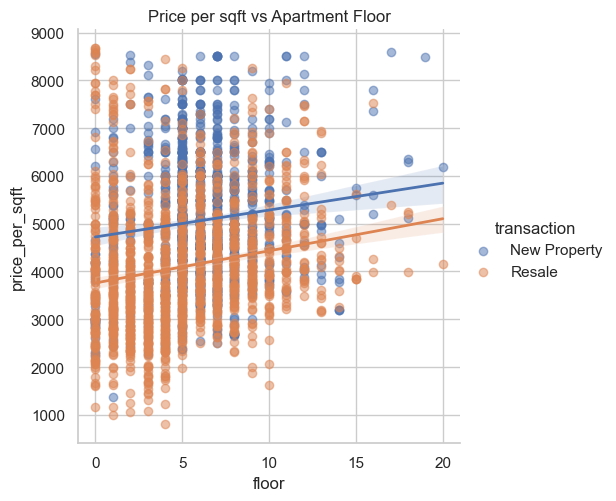

In [12]:
sns.lmplot(
    data=df,
    x="floor",
    y="price_per_sqft",
    hue="transaction",  
    height=5,          
    aspect=1,        
    scatter_kws={'alpha': 0.5}, 
    line_kws={'linewidth': 2}  
)

plt.title("Price per sqft vs Apartment Floor")
plt.show()

Finally, testing out the relationship between ``price_per_sqft`` and the ``floor_ratio``, we finally see deeply the truth about the premium. 

- The blue line (``New Property``): there a slight increasing trend, which means that developers typically employ a systematic pricing strategy for new projects: the higher the floor, the better the view and ventilation means the higher the price tag

- The orange line (``Resale``): the developer’s original price sheet becomes irrelevant during resale transaction. Market dynamics take over everything. It also seems that buyers tend to into medium floor (floor_ratio =  [0.4, 0.6]) or even the ground or basement.

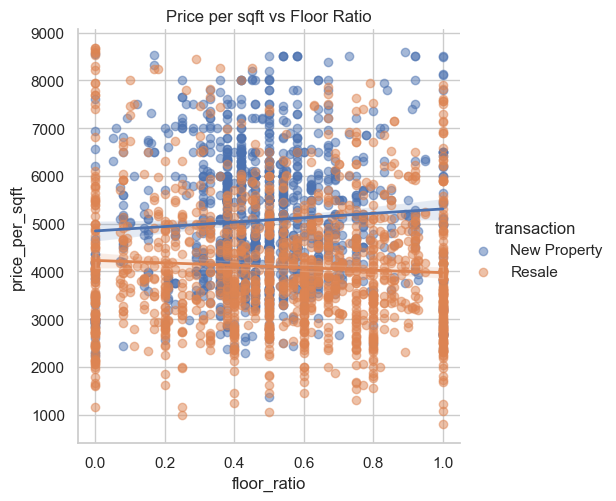

In [13]:
sns.lmplot(
    data=df,
    x="floor_ratio",
    y="price_per_sqft",
    hue="transaction",  
    height=5,          
    aspect=1,        
    scatter_kws={'alpha': 0.5}, 
    line_kws={'linewidth': 2}  
)

plt.title("Price per sqft vs Floor Ratio")
plt.show()

If I divide the two types of building as mentioning above, we can see clearly the trend in two different markets: 
- Primary Market: there is a premium in high building which may be luxury and has a better equipment or view. Especially, most of the time ``New Property`` always more expensive than ``Resale`` since people may want to custom their own apartment
- Secondary Market: there is no premium here, both ``New Property`` and ``Resale`` trends are sus. This maybe being affected by other thing such as ``furnishing``.

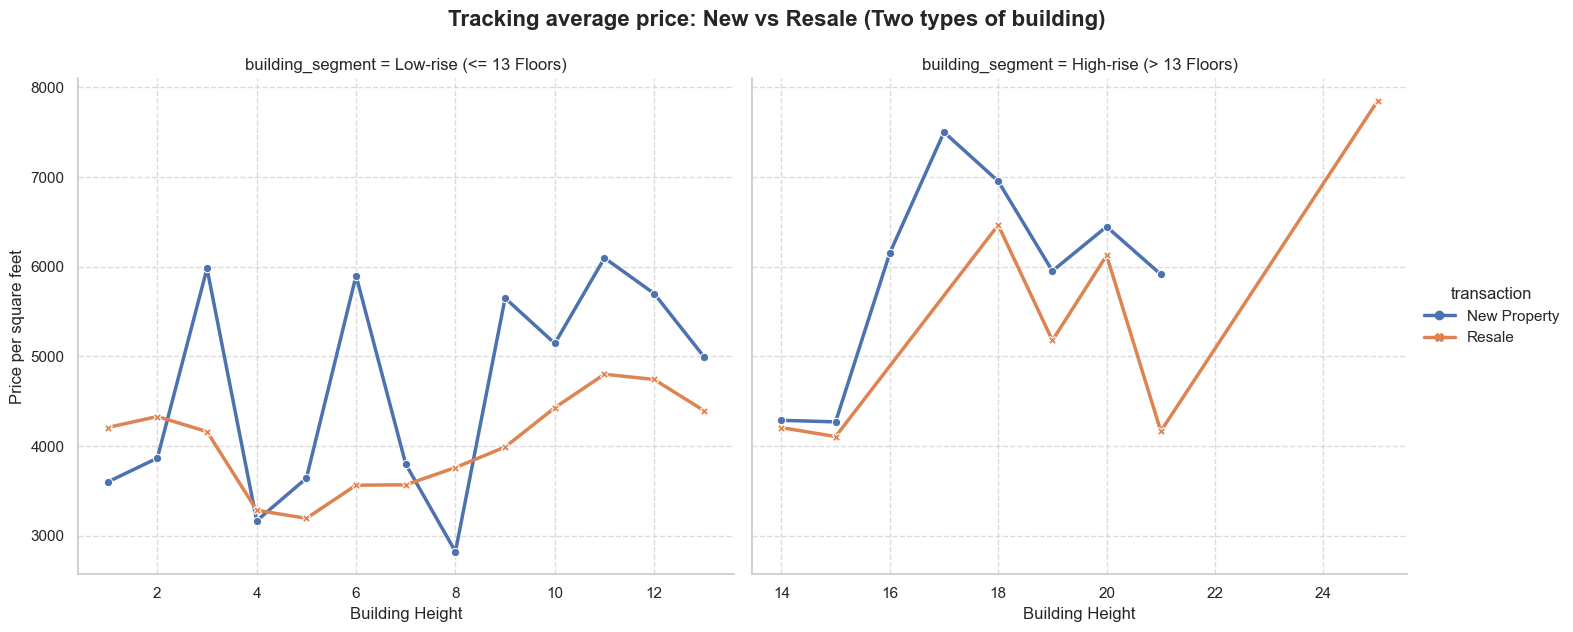

In [24]:
df['building_segment'] = df['num_floor'].apply(lambda x: 'Low-rise (<= 13 Floors)' if x <= 13 else 'High-rise (> 13 Floors)')

g = sns.relplot(
    data=df,
    kind="line",            
    x="num_floor",
    y="price_per_sqft",
    hue="transaction",      
    col="building_segment",
    style="transaction",    
    markers=True,         
    dashes=False,     
    height=6,
    aspect=1.2,
    errorbar=None,          
    linewidth=2.5,     
    facet_kws={'sharex': False, 'sharey': True} 
)

g.fig.suptitle('Tracking average price: New vs Resale (Two types of building)', y=1.05, fontsize=16, fontweight='bold')
g.set_axis_labels("Building Height", "Price per square feet")

for ax in g.axes.flat:
    ax.grid(True, linestyle='--', alpha=0.7)

plt.show()

## 3.2 Floor Effect and How it differs by ``Furnishing``

So we have analyzed the effect of ``New Property`` from ``transaction`` to how the floor effects the price. However, ``Resale`` shows a slight different so we need to analyze more with furnishing

In [14]:
df_resale = df[df['transaction'] == 'Resale'].copy()

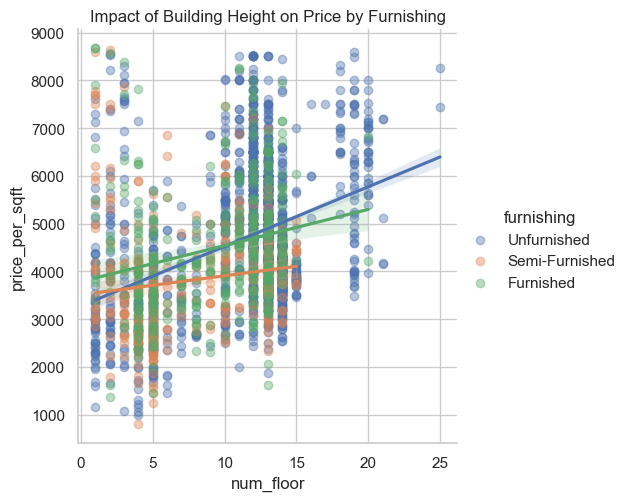

In [15]:
sns.lmplot(
    data=df,
    x="num_floor",
    y="price_per_sqft",
    hue="furnishing",
    height=5, 
    aspect=1,
    scatter_kws={'alpha': 0.4}
)
plt.title("Impact of Building Height on Price by Furnishing")
plt.show()

- There is a clear positive correlation. Taller buildings (likely modern high-rises) generally command a higher price per square foot than low-rise structures.
- The ``Unfurnished`` category exhibits the steepest slope. This suggests that in taller buildings, buyers place a premium on the unit itself.

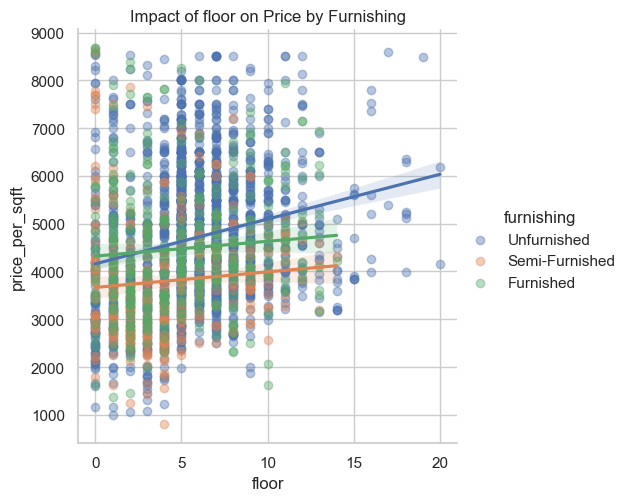

In [16]:
sns.lmplot(
    data=df,
    x="floor",
    y="price_per_sqft",
    hue="furnishing",
    height=5, 
    aspect=1,
    scatter_kws={'alpha': 0.4}
)
plt.title("Impact of floor on Price by Furnishing")
plt.show()

- Higher floors correlate with higher prices, reflecting the premium paid for better views and reduced noise
- ``Unfurnished`` units show the strongest price appreciation as the floor level increases. In contrast, the trend line for ``Semi-Furnished`` units is nearly flat

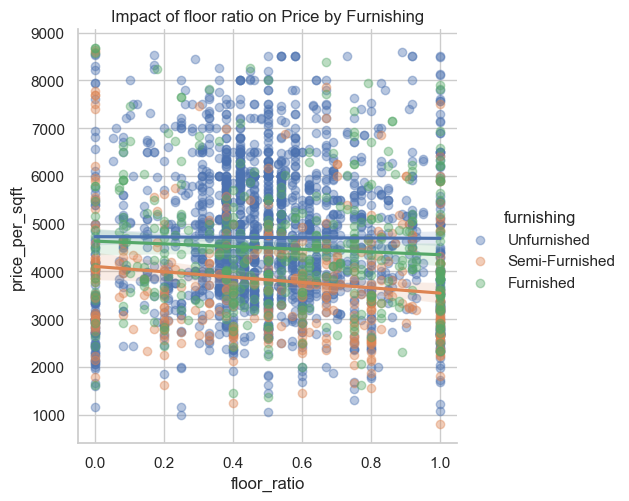

In [17]:
sns.lmplot(
    data=df,
    x="floor_ratio",
    y="price_per_sqft",
    hue="furnishing",
    height=5, 
    aspect=1,
    scatter_kws={'alpha': 0.4}
)
plt.title("Impact of floor ratio on Price by Furnishing")
plt.show()

- Relative position is statistically insignificant compared to absolute height. Being on the top floor of a low-rise building does not carry the same value proposition as being on a mid-level floor of a skyscraper

# 4. Conclusion & Recommendation

## 4.1 Final Conclusion

**Floor effect exists** in residential property prices; however, it is not uniform. The effect is highly moderated by the type of transaction (``New Property`` vs. ``Resale``) and the level of furnishing.

- **The Divergence of Pricing in Markets:**
    - **Primary Market -> Supply-Side Pricing:** There is a large positive correlation between floor level and price. This reflects the *Developer’s Premium*, where pricing strategies implicitly assign higher value to higher floors due to attributes like view, ventilation, and privacy. 
    - **Secondary Market -> Demand-Side Valuation:** The *Developer’s Premium* mostly disappears in the secondary market. the market has adjusted away from the original pricing structure. Instead of paying extra for higher floors, buyers tend to focus on practical factors like convenience and ease of access. As a result, mid-level floors (around 0.4–0.6 of the building height) or units closer to the ground are often preferred, likely due to elevator waiting times, everyday convenience, and safety considerations.

- **The Proxy of Building Height:** Price per square foot clearly increases with the total height of the building. In practice, building height acts as a signal of overall property quality. Taller buildings are usually newer developments with better amenities and are often located in more desirable, high-value areas. In contrast, low-rise buildings (under 14 floors) tend to be older properties and are associated with lower resale prices.

- **The Moderating Role of Furnishing:** The impact of floor level also varies by furnishing status. Unfurnished units show the strongest price response to building height, suggesting that empty units in high-rise buildings appeal to a luxury segment where buyers are willing to pay extra for the freedom to design the space to their own taste. In contrast, semi-furnished units show little change in price across different floors, indicating that for these buyers, the usefulness of existing fittings matters more than how high the unit is located.

## 4.2 Recommendation

- Recommendation for Buyers:
    - **Primary Market Buyers (New Property)**: Higher floors carry a developer-driven premium, not always proportional to real utility. Therefore, buyers should avoid overpaying for height unless view, privacy, or status is a priority
    - **Secondary Market Buyers (Resale)**: Lower to mid floors provide better value due to convenience and accessibility, Buyers should prioritize usability over symbolic value of higher floors

- Recommendation for Developers/Investors: Use floor-based pricing more selectively: strong premiums are justified mainly in new, high-rise projects and avoid overpricing higher floors in low-rise buildings